In [1]:
!pip install lime alibi openpyxl shap


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [4]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lime
import lime.lime_tabular
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay

warnings.filterwarnings("ignore")

In [5]:
# Load the dataset
df = pd.read_excel("data.xlsx", sheet_name="Part3")

# Display first few rows and column names
print("Dataset Preview:")
print(df.head())
print("\nColumn Names:")
print(df.columns.tolist())
print("\nDataset Shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

# Check for the target variable - it should be a binary classification variable
# Look for columns that might indicate default/risk/target
print("\nValue counts for each column:")
for col in df.columns:
    print(f"\n{col}:")
    print(df[col].value_counts())

Dataset Preview:
   RetirementAge  DebtAmount  MonthlySavings  LoanDefaultRisk
0           60.0     2996.52         2378.49                0
1           66.4     4137.23         1538.92                1
2           58.5    19865.75         2434.80                1
3           49.8    16855.70         2677.82                1
4           67.3     7902.37         2206.72                0

Column Names:
['RetirementAge', 'DebtAmount', 'MonthlySavings', 'LoanDefaultRisk']

Dataset Shape: (300, 4)

Data Types:
RetirementAge      float64
DebtAmount         float64
MonthlySavings     float64
LoanDefaultRisk      int64
dtype: object

Value counts for each column:

RetirementAge:
RetirementAge
61.4    5
67.3    4
69.7    4
71.5    3
62.4    3
       ..
40.4    1
76.7    1
57.5    1
51.0    1
56.0    1
Name: count, Length: 214, dtype: int64

DebtAmount:
DebtAmount
2996.52     1
3980.36     1
3711.64     1
15923.69    1
1512.80     1
           ..
35788.42    1
7062.48     1
41136.33    1
1037.16

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Define the model and parameter grid for grid search
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 10, None],
    'min_samples_leaf': [1, 2, 4]
}

# Perform grid search with 5-fold cross-validation
print("\n" + "="*70)
print("QUESTION 1: RANDOM FOREST GRID SEARCH")
print("="*70)
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    cv=5, 
    scoring='roc_auc', 
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)


QUESTION 1: RANDOM FOREST GRID SEARCH
Fitting 5 folds for each of 36 candidates, totalling 180 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': [3, 5, ...], 'min_samples_leaf': [1, 2, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,150


In [7]:
# Get the best model and make predictions
best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)

# Print results
print("\nBest Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation ROC-AUC Score: {grid_search.best_score_:.4f}")
print(f"Test Set ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba[:, 1]):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 150}
Best Cross-Validation ROC-AUC Score: 0.9846
Test Set ROC-AUC Score: 0.9886

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93        38
           1       0.92      0.95      0.93        37

    accuracy                           0.93        75
   macro avg       0.93      0.93      0.93        75
weighted avg       0.93      0.93      0.93        75



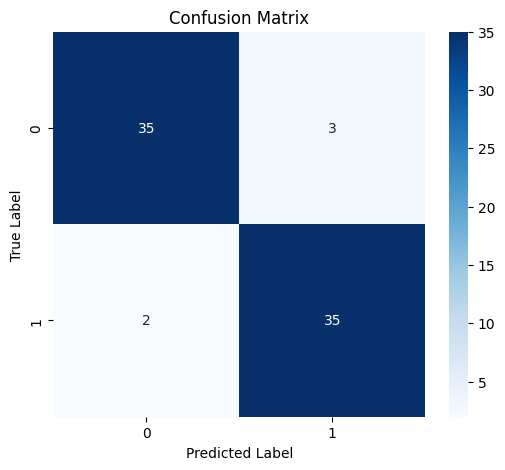

In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [9]:
# Select a single observation to explain
instance_idx = 0
instance_to_explain = X_test.iloc[[instance_idx]]
true_label = y_test.iloc[instance_idx]

print(f"\nExplaining instance {instance_idx}")
print(f"True label: {true_label}")
print(f"Predicted probability: {best_rf_model.predict_proba(instance_to_explain)[0]}")


Explaining instance 0
True label: 1
Predicted probability: [0.04258729 0.95741271]


In [11]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X.columns.tolist(),
    class_names=['Class 0', 'Class 1'],  # Update with actual class names
    mode='classification'
)
explanation_lime = explainer_lime.explain_instance(
    data_row=instance_to_explain.values[0],
    predict_fn=best_rf_model.predict_proba,
    num_features=len(X.columns)
)

In [12]:
explanation_data = explanation_lime.as_list()
print("\nLIME Feature Contributions:")
for feature, weight in explanation_data:
    print(f"  {feature}: {weight:.4f}")


LIME Feature Contributions:
  DebtAmount > 17110.03: 0.4389
  1687.59 < MonthlySavings <= 2009.22: 0.1325
  64.90 < RetirementAge <= 72.10: -0.0812


In [15]:
explainer_shap = shap.TreeExplainer(best_rf_model)
shap_values = explainer_shap.shap_values(X_test)

In [16]:
shap_values_for_single_instance = shap_values[instance_idx, :, 1]
features_for_single_instance = X_test.iloc[instance_idx, :]
base_value = explainer_shap.expected_value[1]

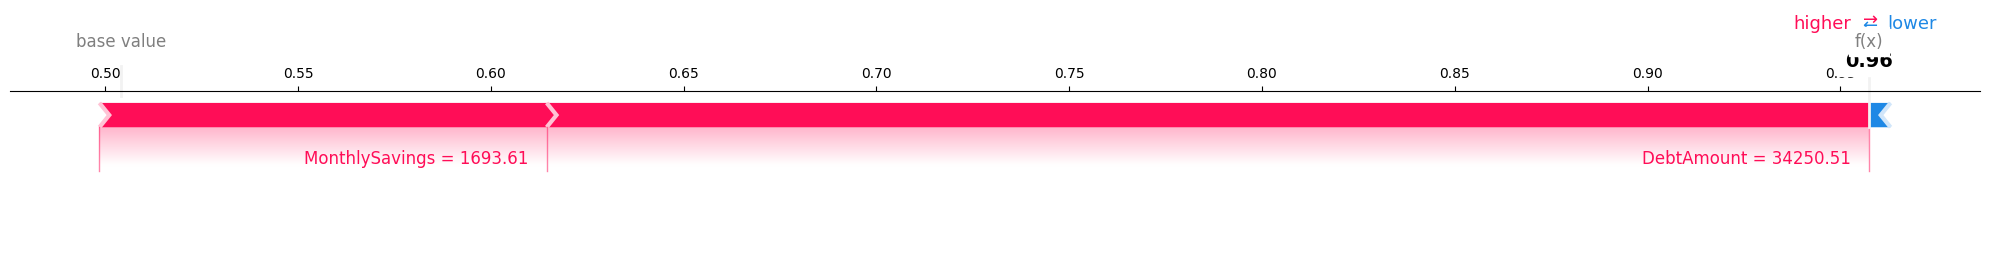

In [17]:
shap.force_plot(
    base_value,
    shap_values_for_single_instance,
    features_for_single_instance,
    matplotlib=True,
    show=False
)
plt.tight_layout()
plt.show()

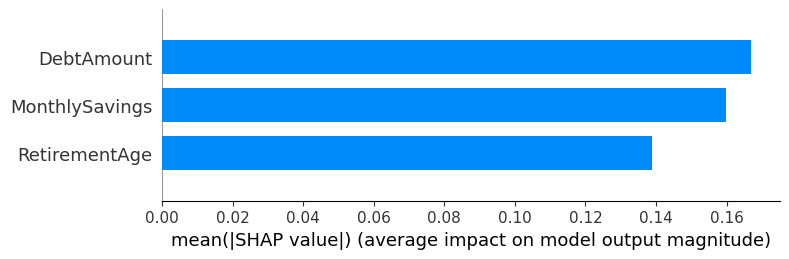

In [18]:
shap_values_class_1 = shap_values[:, :, 1]
plt.figure()
shap.summary_plot(shap_values_class_1, X_test, plot_type="bar", show=False)
plt.tight_layout()
plt.show()

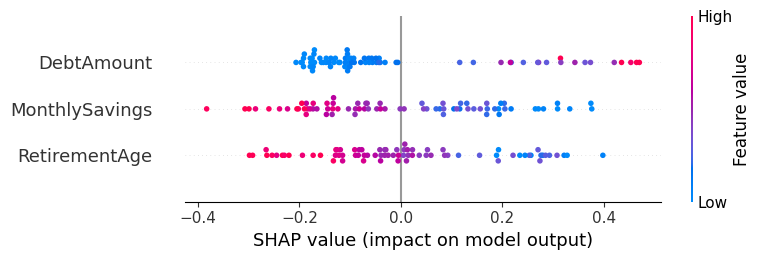

In [19]:
plt.figure()
shap.summary_plot(shap_values_class_1, X_test, show=False)
plt.tight_layout()
plt.show()


Generating dependence plot for: RetirementAge


<Figure size 800x500 with 0 Axes>

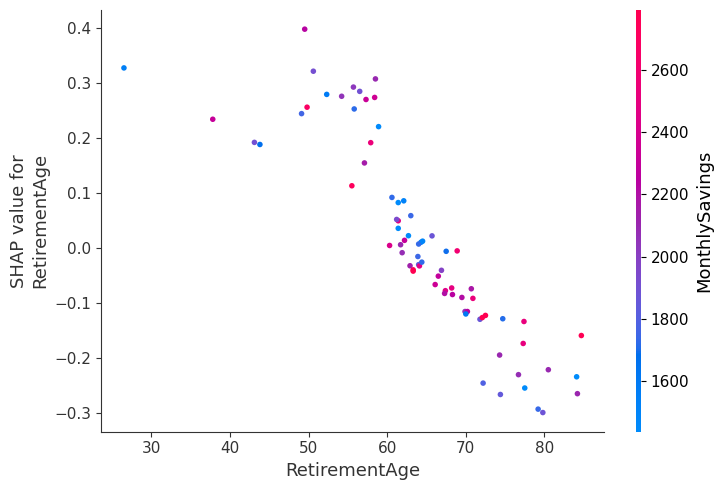


Generating dependence plot for: DebtAmount


<Figure size 800x500 with 0 Axes>

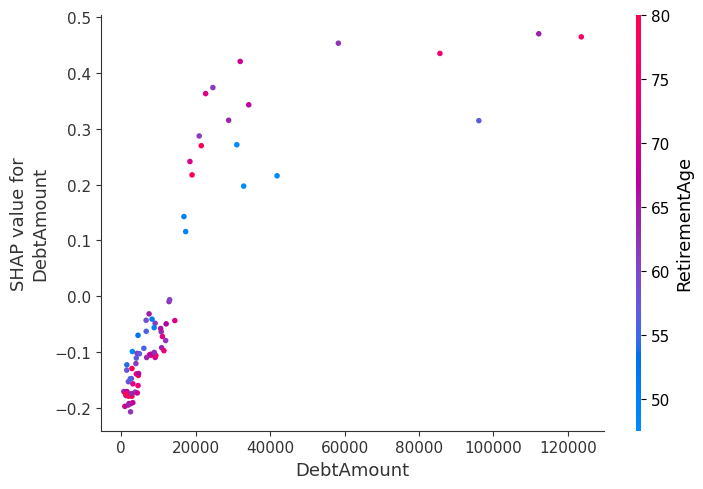


Generating dependence plot for: MonthlySavings


<Figure size 800x500 with 0 Axes>

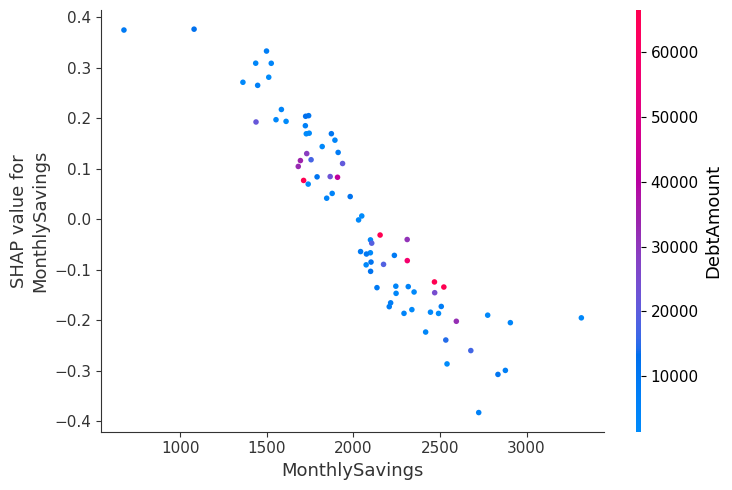

In [20]:
for col in X_test.columns:
    print(f"\nGenerating dependence plot for: {col}")
    plt.figure(figsize=(8, 5))
    shap.dependence_plot(
        col, 
        shap_values_class_1, 
        X_test, 
        interaction_index="auto",
        show=False
    )
    plt.tight_layout()
    plt.show()

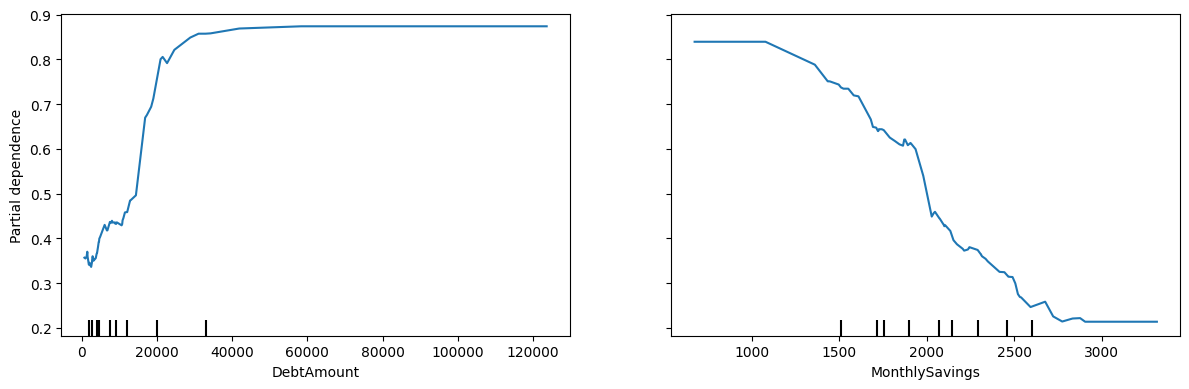

In [21]:
feature_importance = best_rf_model.feature_importances_
top_features_idx = np.argsort(feature_importance)[-2:]
top_features = X.columns[top_features_idx].tolist()

fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    best_rf_model, 
    X_test, 
    features=top_features_idx,
    ax=ax
)
plt.tight_layout()
plt.show()